2025-03-03 10:58:36.833979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-03 10:58:36.834018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-03 10:58:36.835132: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 10:58:36.841057: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.10/dist-packages

1/1 [==============================] - 1s 845ms/step
Predictions:
lynx: 29.38%
plastic_bag: 14.75%
tiger_cat: 8.90%


  0%|                                                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 91ms/step


 10%|█████████████████▋                                                                                                                                                               | 10/100 [00:00<00:01, 66.81it/s]

1/1 [==============================] - 0s 87ms/step


 20%|███████████████████████████████████▍                                                                                                                                             | 20/100 [00:00<00:01, 67.73it/s]

1/1 [==============================] - 0s 85ms/step


 30%|█████████████████████████████████████████████████████                                                                                                                            | 30/100 [00:00<00:01, 69.43it/s]

1/1 [==============================] - 0s 87ms/step


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 40/100 [00:00<00:00, 68.63it/s]

1/1 [==============================] - 0s 87ms/step


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 50/100 [00:00<00:00, 68.69it/s]

1/1 [==============================] - 0s 86ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 60/100 [00:00<00:00, 68.79it/s]

1/1 [==============================] - 0s 86ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 70/100 [00:01<00:00, 68.72it/s]

1/1 [==============================] - 0s 86ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 80/100 [00:01<00:00, 68.77it/s]

1/1 [==============================] - 0s 84ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 90/100 [00:01<00:00, 69.36it/s]

1/1 [==============================] - 0s 82ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.02it/s]


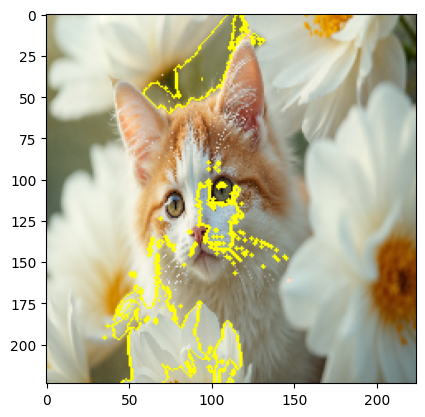

'\ndef grad_cam(img_array, model, layer_name="block_15_project"): #common last layer for MobileNetV2\n    grad_model = tf.keras.models.Model(\n        [model.inputs], [model.get_layer(layer_name).output, model.output]\n    )\n    with tf.GradientTape() as tape:\n        conv_outputs, predictions = grad_model(img_array)\n        loss = predictions[:, np.argmax(predictions[0])]\n\n    grads = tape.gradient(loss, conv_outputs)\n    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))\n    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)\n    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)\n    return heatmap.numpy()[0]\n\nheatmap = grad_cam(preprocessed_img, model)\n\n# Overlay heatmap on original image\noriginal_img_array = image.img_to_array(original_img) / 255.0\nheatmap = cv2.resize(heatmap, (original_img_array.shape[1], original_img_array.shape[0]))\nheatmap = np.uint8(255 * heatmap)\nheatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)\nsuperimposed_im

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Load a pre-trained MobileNetV2 model (for simplicity, we'll use it for classification)
model = MobileNetV2(weights='imagenet')

# Load and preprocess an image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array, img

# Load image and preprocess
img_path = 'images/cat.jpg' # Replace with your image path
preprocessed_img, original_img = preprocess_image(img_path)

# Make a prediction
predictions = model.predict(preprocessed_img)
decoded_predictions = tf.keras.applications.mobilenet_v2.decode_predictions(predictions, top=3)[0]

print("Predictions:")
for _, label, confidence in decoded_predictions:
    print(f"{label}: {confidence * 100:.2f}%")

# LIME Explanation (for image classification)
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=image.img_to_array(original_img),
    classifier_fn=model.predict,
    top_labels=1,
    hide_color=0,
    num_samples=100
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(image.img_to_array(original_img) / 255.0, mask))
plt.show()

# Grad-CAM (Gradient-weighted Class Activation Mapping)
'''
def grad_cam(img_array, model, layer_name="block_15_project"): #common last layer for MobileNetV2
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap.numpy()[0]

heatmap = grad_cam(preprocessed_img, model)

# Overlay heatmap on original image
original_img_array = image.img_to_array(original_img) / 255.0
heatmap = cv2.resize(heatmap, (original_img_array.shape[1], original_img_array.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + original_img_array * 0.6
plt.imshow(superimposed_img)
plt.show()
'''